In [ ]:
import pandas as pd

# Input data
data = {
    'Operation': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    'Predecessors': [
        None, [1], None, [2], [3,4], None, [5,6], [7], [8], [9], [10], [11], [12], [13], [14], [15], None, [16,17], [18], [19], [20], [21], [22], [23]
    ],
    'SMV': [
        0.40, 0.28, 0.40, 0.78, 0.68, 0.20, 0.56, 0.25, 0.50, 0.28, 0.37, 0.25, 0.42, 0.68, 0.30, 0.60, 0.14, 0.28, 0.17, 0.50, 0.27, 0.26, 0.16, 0.24
    ]
}

# Parameters
CYCLE_TIME = 0.78

# Create DataFrame
df = pd.DataFrame(data)

# Calculate Ranked Positional Weights (RPW)
def calculate_rpw(df):
    rpw = {}
    for _, row in df.iterrows():
        op = row['Operation']
        rpw[op] = row['SMV'] + sum(
            df.loc[df['Operation'] == succ, 'SMV'].values[0]
            for succ in get_all_successors(df, op)
        )
    return rpw

# Helper function to get all successors
def get_all_successors(df, op):
    successors = []
    for _, row in df.iterrows():
        if row['Predecessors'] and op in row['Predecessors']:
            successors.append(row['Operation'])
            successors.extend(get_all_successors(df, row['Operation']))
    return list(set(successors))

# RPW Balancing Algorithm
def rpw_balance(df, cycle_time):
    rpw = calculate_rpw(df)
    df['RPW'] = df['Operation'].map(rpw)
    df_sorted = df.sort_values('RPW', ascending=False)

    workstations = []
    assigned = set()
    predecessors_done = set()

    while len(assigned) < len(df_sorted):
        remaining_time = cycle_time
        current_ws = []

        for _, row in df_sorted.iterrows():
            op = row['Operation']
            smv = row['SMV']
            preds = row['Predecessors'] if row['Predecessors'] else []

            if (op not in assigned and
                all(p in predecessors_done for p in preds) and
                smv <= remaining_time):

                current_ws.append(op)
                assigned.add(op)
                predecessors_done.add(op)
                remaining_time -= smv

        if current_ws:
            workstations.append({
                'Operations': current_ws,
                'Total Time': cycle_time - remaining_time,
                'Idle Time': remaining_time
            })

    return workstations

# Run balancing
workstations = rpw_balance(df, CYCLE_TIME)

# Calculate metrics
total_smv = df['SMV'].sum()
total_workstations = len(workstations)
efficiency = (total_smv / (total_workstations * CYCLE_TIME)) * 100
total_idle_time = sum(ws['Idle Time'] for ws in workstations)

# Print results
print("=== Ranked Positional Weight (RPW) Line Balancing ===")
print(f"Cycle Time: {CYCLE_TIME} min")
print(f"Total SMV: {total_smv:.2f} min")
print(f"Workstations Required: {total_workstations}")
print(f"Efficiency: {efficiency:.1f}%")
print(f"Total Idle Time: {total_idle_time:.2f} min\n")

print("Workstation Assignments:")
ws_df = pd.DataFrame(workstations)
ws_df.index += 1  # Start workstation numbering at 1
print(ws_df[['Operations', 'Total Time', 'Idle Time']].to_string())

=== Ranked Positional Weight (RPW) Line Balancing ===
Cycle Time: 0.78 min
Total SMV: 8.97 min
Workstations Required: 14
Efficiency: 82.1%
Total Idle Time: 1.95 min

Workstation Assignments:
      Operations  Total Time  Idle Time
1         [1, 2]        0.68       0.10
2            [4]        0.78       0.00
3     [3, 6, 17]        0.74       0.04
4            [5]        0.68       0.10
5            [7]        0.56       0.22
6         [8, 9]        0.75       0.03
7       [10, 11]        0.65       0.13
8       [12, 13]        0.67       0.11
9           [14]        0.68       0.10
10          [15]        0.30       0.48
11          [16]        0.60       0.18
12      [18, 19]        0.45       0.33
13      [20, 21]        0.77       0.01
14  [22, 23, 24]        0.66       0.12



=== Efficiency Analysis ===
Maximum Efficiency: 99.89% at Cycle Time: 8.98 minutes
Current Efficiency: 76.67% at Cycle Time: 0.9 minutes
Potential Improvement: 23.22 percentage points


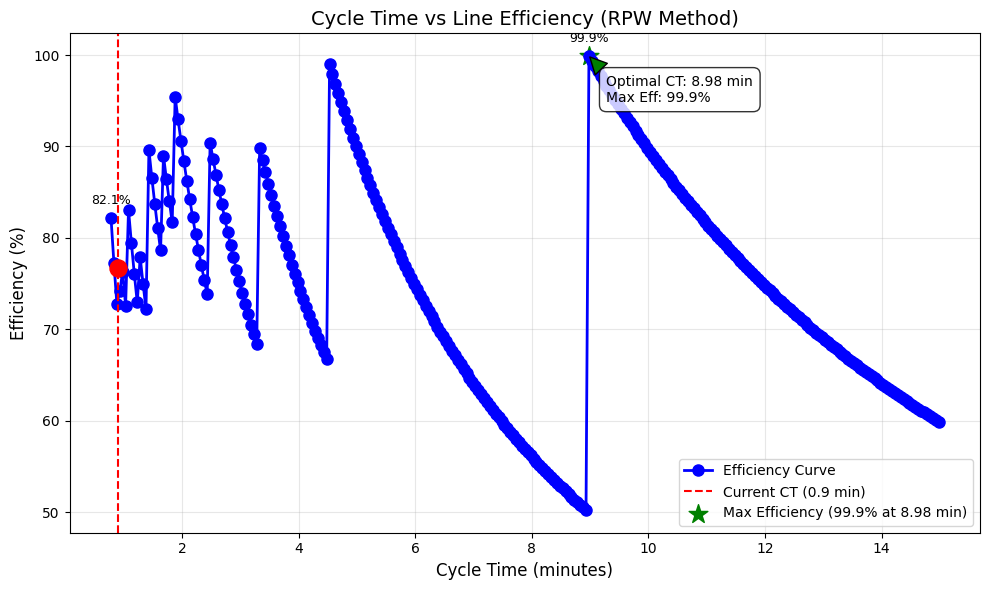

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate efficiency for a given cycle time
def calculate_efficiency(df, cycle_time):
    workstations = rpw_balance(df, cycle_time)
    total_smv = df['SMV'].sum()
    efficiency = (total_smv / (len(workstations) * cycle_time)) * 100
    return efficiency

# Generate cycle time range (0.78 to 3.0 min in steps of 0.05)
cycle_times = np.arange(0.78, 15.01, 0.05)
efficiencies = [calculate_efficiency(df, ct) for ct in cycle_times]

# Find maximum efficiency point
max_eff = max(efficiencies)
max_eff_idx = np.argmax(efficiencies)
optimal_ct = cycle_times[max_eff_idx]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cycle_times, efficiencies, 'bo-', linewidth=2, markersize=8, label='Efficiency Curve')

# Highlight current cycle time (0.90 min)
current_ct = 0.90
current_eff = calculate_efficiency(df, current_ct)
plt.axvline(x=current_ct, color='r', linestyle='--', linewidth=1.5, label=f'Current CT ({current_ct} min)')
plt.scatter(current_ct, current_eff, color='red', s=150, zorder=5)

# Highlight maximum efficiency point
plt.scatter(optimal_ct, max_eff, color='green', s=200, marker='*',
           label=f'Max Efficiency ({max_eff:.1f}% at {optimal_ct:.2f} min)')

# Add annotation for maximum efficiency
plt.annotate(f'Optimal CT: {optimal_ct:.2f} min\nMax Eff: {max_eff:.1f}%',
            xy=(optimal_ct, max_eff),
            xytext=(optimal_ct+0.3, max_eff-5),
            arrowprops=dict(facecolor='green', shrink=0.05),
            fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

# Add efficiency values as annotations
for ct, eff in zip(cycle_times, efficiencies):
    if ct in [0.78, 0.9, 1.0, 1.2, 1.5, optimal_ct]:  # Label key points
        plt.annotate(f'{eff:.1f}%', (ct, eff), textcoords="offset points",
                    xytext=(0,10), ha='center', fontsize=9)

plt.xlabel('Cycle Time (minutes)', fontsize=12)
plt.ylabel('Efficiency (%)', fontsize=12)
plt.title('Cycle Time vs Line Efficiency (RPW Method)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()

# Print analysis results
print("\n=== Efficiency Analysis ===")
print(f"Maximum Efficiency: {max_eff:.2f}% at Cycle Time: {optimal_ct:.2f} minutes")
print(f"Current Efficiency: {current_eff:.2f}% at Cycle Time: {current_ct} minutes")
print(f"Potential Improvement: {max_eff - current_eff:.2f} percentage points")

plt.show()